### **Data Generation**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
n_customers = 5000
data = pd.DataFrame({
    'CustomerID': np.arange(1, n_customers + 1),
    'Age': np.random.randint(18, 70, size=n_customers),
    'Gender': np.random.choice(['Male', 'Female'], size=n_customers),
    'ContractType': np.random.choice(['Month-to-month', 'One year', 'Two year'], size=n_customers),
    'MonthlyCharges': np.round(np.random.uniform(20, 120, size=n_customers), 2),
    'TotalCharges': np.round(np.random.uniform(100, 5000, size=n_customers), 2),
    'TechSupport': np.random.choice(['Yes', 'No'], size=n_customers),
    'InternetService': np.random.choice(['DSL', 'Fiber optic', 'No'], size=n_customers),
    'Tenure': np.random.randint(1, 72, size=n_customers),
    'PaperlessBilling': np.random.choice(['Yes', 'No'], size=n_customers),
    'PaymentMethod': np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'], size=n_customers)
})

# Derived features
data['average_monthly_charges'] = data['TotalCharges'] / data['Tenure']
data['customer_lifetime_value'] = data['Tenure'] * data['MonthlyCharges']

# Introduce outliers
data.loc[data.sample(frac=0.01).index, 'MonthlyCharges'] *= 3

# Introduce missing values
data.loc[data.sample(frac=0.05).index, 'TotalCharges'] = np.nan

# Assign churn with 20% probability
data['Churn'] = np.random.choice(['Yes', 'No'], size=n_customers, p=[0.2, 0.8])

print(data.head())


   CustomerID  Age  Gender    ContractType  MonthlyCharges  TotalCharges  \
0           1   56    Male        One year          107.19       2659.17   
1           2   69  Female  Month-to-month           88.74       2630.01   
2           3   46  Female  Month-to-month           31.16       3488.69   
3           4   32    Male        Two year           34.77        334.83   
4           5   60    Male        One year           62.81       3578.49   

  TechSupport InternetService  Tenure PaperlessBilling  \
0         Yes             DSL      37              Yes   
1         Yes              No      24              Yes   
2         Yes     Fiber optic      62              Yes   
3          No              No      21              Yes   
4         Yes             DSL      37              Yes   

               PaymentMethod  average_monthly_charges  \
0  Bank transfer (automatic)                71.869459   
1               Mailed check               109.583750   
2           Electronic 

### **Exploratory Data Analysis (EDA)**

        CustomerID          Age  MonthlyCharges  TotalCharges       Tenure  \
count  5000.000000  5000.000000     5000.000000   4750.000000  5000.000000   
mean   2500.500000    43.584600       71.424036   2526.731777    36.118200   
std    1443.520003    14.919094       32.443556   1406.134097    20.404624   
min       1.000000    18.000000       20.010000    100.050000     1.000000   
25%    1250.750000    31.000000       45.837500   1304.910000    19.000000   
50%    2500.500000    43.000000       70.950000   2520.170000    36.000000   
75%    3750.250000    56.000000       95.300000   3719.967500    54.000000   
max    5000.000000    69.000000      353.310000   4999.470000    71.000000   

       average_monthly_charges  customer_lifetime_value  
count              5000.000000              5000.000000  
mean                167.923798              2542.158380  
std                 393.727826              1863.504082  
min                   1.495211                21.000000  
25%    

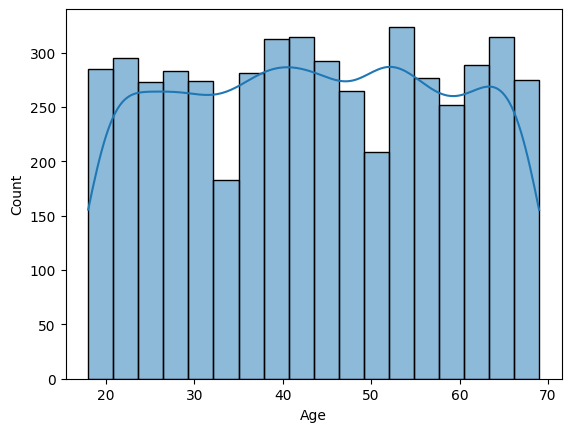

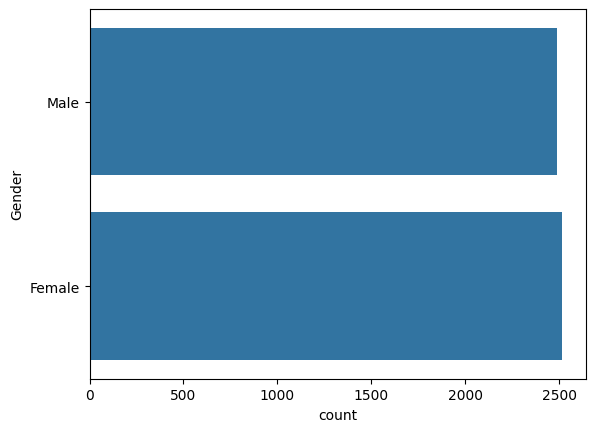

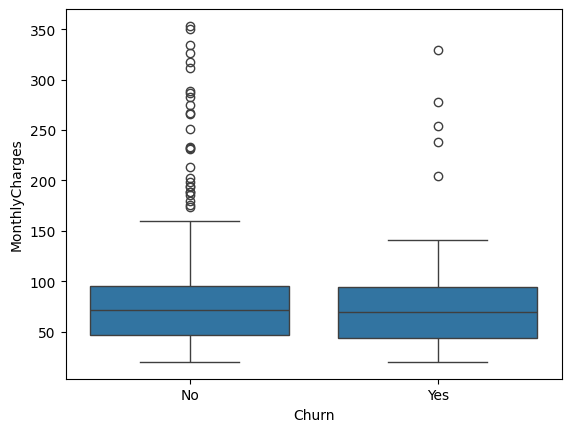

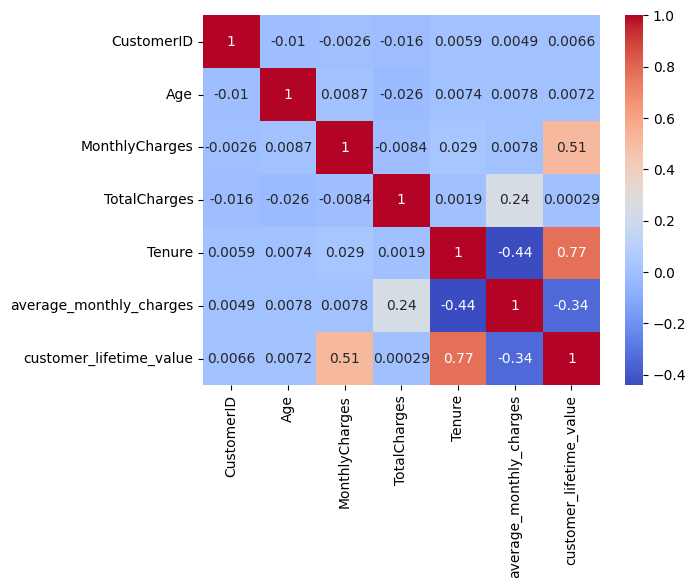

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Summary statistics
print(data.describe())

# Visualize distributions
sns.histplot(data['Age'], kde=True)
plt.show()

sns.countplot(data['Gender'])
plt.show()

sns.boxplot(x='Churn', y='MonthlyCharges', data=data)
plt.show()

# Select only numeric columns for the correlation matrix
numeric_data = data.select_dtypes(include=[np.number])

# Correlation matrix
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


### **Data Preprocessing**

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Handle missing values
imputer = SimpleImputer(strategy='median')
data['TotalCharges'] = imputer.fit_transform(data[['TotalCharges']])

# Encode categorical features
categorical_features = ['Gender', 'ContractType', 'TechSupport', 'InternetService', 'PaperlessBilling', 'PaymentMethod']
encoder = OneHotEncoder(drop='first')
encoded_data = pd.DataFrame(encoder.fit_transform(data[categorical_features]).toarray(), columns=encoder.get_feature_names_out())

# Combine with the rest of the data
data = pd.concat([data.drop(columns=categorical_features), encoded_data], axis=1)

# Split the data
X = data.drop(columns=['CustomerID', 'Churn'])
y = LabelEncoder().fit_transform(data['Churn'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


### **Feature Engineering**

In [5]:
# Assuming we've already created derived features earlier
# Feature scaling (if required)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### **Model Building**

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
param_grid_lr = {'C': [0.01, 0.1, 1, 10]}
grid_lr = GridSearchCV(logreg, param_grid_lr, cv=5, scoring='precision')
grid_lr.fit(X_train_scaled, y_train)

# Decision Tree
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
param_grid_tree = {'min_samples_split': [2, 10, 20], 'min_samples_leaf': [1, 5, 10]}
grid_tree = GridSearchCV(tree, param_grid_tree, cv=5, scoring='precision')
grid_tree.fit(X_train, y_train)

# Evaluate models
best_model = grid_lr if grid_lr.best_score_ > grid_tree.best_score_ else grid_tree
y_pred = best_model.predict(X_test_scaled if best_model == grid_lr else X_test)

print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, best_model.predict_proba(X_test_scaled if best_model == grid_lr else X_test)[:, 1])}")

import joblib

# Save the best model
best_model_name = "best_model_lr.pkl" if best_model == grid_lr else "best_model_tree.pkl"
joblib.dump(best_model, best_model_name)

print(f"Model saved as {best_model_name}")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

              precision    recall  f1-score   support

           0       0.80      0.98      0.88       800
           1       0.19      0.01      0.03       200

    accuracy                           0.79      1000
   macro avg       0.49      0.50      0.46      1000
weighted avg       0.68      0.79      0.71      1000

ROC AUC: 0.508328125
Model saved as best_model_tree.pkl


### **Model Selection and Evaluation**

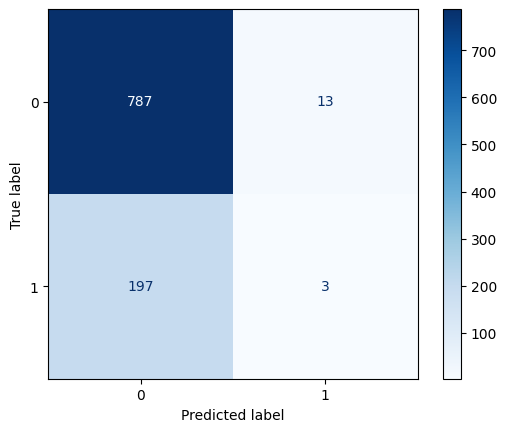

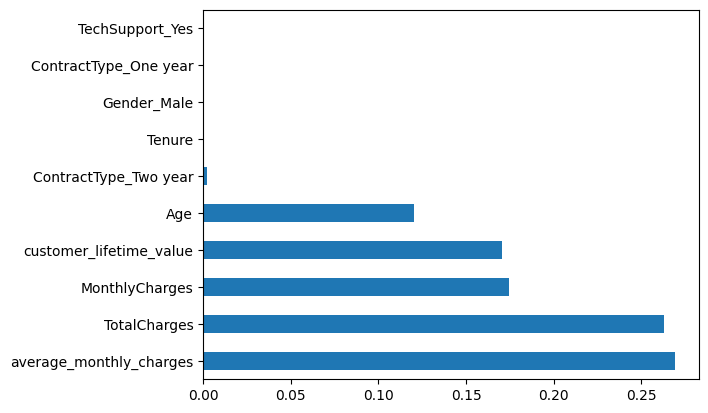

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

# Feature Importance
if hasattr(best_model.best_estimator_, 'coef_'):
    importance = pd.Series(best_model.best_estimator_.coef_[0], index=X.columns)
else:
    importance = pd.Series(best_model.best_estimator_.feature_importances_, index=X.columns)

importance.nlargest(10).plot(kind='barh')
plt.show()


### **Model Deployment**

In [7]:
# Load the saved model
best_model_loaded = joblib.load(best_model_name)

# Use the loaded model for predictions or evaluations
y_pred_loaded = best_model_loaded.predict(X_test_scaled if best_model == grid_lr else X_test)
print(classification_report(y_test, y_pred_loaded))


              precision    recall  f1-score   support

           0       0.80      0.98      0.88       800
           1       0.19      0.01      0.03       200

    accuracy                           0.79      1000
   macro avg       0.49      0.50      0.46      1000
weighted avg       0.68      0.79      0.71      1000

